- http://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/

In [1]:
import sys
import os
from os import path,listdir
import subprocess
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import gzip
import pygraphviz
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

import gc

In [2]:
##################################
### General methods
##################################

def Call(s):
    subprocess.call(s, shell=True, executable='/bin/bash')
    
    
def bed_sort(input_file):
    call = "sort -k1,1 -k2,2n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
    
    
def gtf_sort(input_file):
    call = "sort -k1,1 -k4,4n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
        
        
def microparser(line):
    if len(line.strip())==0:
        return None
    X = line.strip().split('\t')        
    r = {a.split(' ')[0]:a.split(' ')[1].replace('"','') for a in [x.strip() for x in X[8].split(';') if len(x.strip())>0]}
    r.update({'chr':X[0],'start':X[3],'end':X[4],'strand':X[6],'feature':X[2]})
    return r


def parse_meta(text):
    assembly = re.findall('human genome \((.*)\),',text)[0].strip()
    version = re.findall('version (.*) \(',text)[0].strip()
    ensembl = re.findall('Ensembl (.*)\)',text)[0].strip()
    _date = re.findall('date: (.*)',text)[0].strip()
    return {'gencode':version,'assembly':assembly,'ensembl':ensembl,'date':_date}

##################################
### Download gencode
##################################

def download_gencode(output_raw_path,output_gene_path,output_meta_path,max_version=41):
    for folder in [output_raw_path,output_gene_path,output_meta_path]:
        if not path.exists(folder):
            os.makedirs(folder)
    call_download = """wget "ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{version}/gencode.v{version}.annotation.gtf.gz" -P {output_raw_path}
zgrep -P "\\tgene\\t" {output_raw_path}/gencode.v{version}.annotation.gtf.gz | sort -k1,1 -k4,4n | gzip > {output_gene_path}/v{version}.gtf.gz
zcat {output_raw_path}/gencode.v{version}.annotation.gtf.gz | head -n 5 > {output_meta_path}/v{version}.txt
"""
    versions = list(range(5,max_version+1))
    for version in versions:
        output_gene = path.join(output_gene_path,'v%d.gtf.gz'%version)
        if path.exists(output_gene):
            print('# Already processed',output_gene)
            continue
        call = call_download.format(version=version,output_raw_path=output_raw_path,
                                    output_gene_path=output_gene_path,output_meta_path=output_meta_path)
        print(call)
        Call(call)
        

##################################
### Create files for index
##################################

def create_equivalence_table(output_meta_path,output_ensembl_equivalence):
    files = sorted([path.join(output_meta_path,x) for x in listdir(output_meta_path) if x.startswith('v') and x.endswith('.txt')])
    rows = []
    for input_file in files:
        with open(input_file,'r') as f:
            text = ''.join(f.readlines()).replace('\n',' ').strip()
        rows.append(parse_meta(text))
    df = pd.DataFrame(rows).sort_values(by=['date'],ascending=[False])
    df = df[['gencode','ensembl','assembly','date']]
    df.to_csv(output_ensembl_equivalence,index=None)
    print('# Wrote',output_ensembl_equivalence)    
    
    
def create_gene_index(output_gene_path,output_gene_index,max_version=41):
    if not path.exists(output_gene_path):
        os.makedirs(output_gene_path)
    files = sorted([path.join(output_gene_path,x) for x in listdir(output_gene_path) if x.endswith('.gtf.gz')])
    fields = ['gene_id','gene_name','gene_type','hgnc_id']
    rows = []
    for input_file in files:
        version = int(re.findall('v(.*)\.gtf\.gz',input_file)[0])
        print("Reading",input_file)
        with gzip.open(input_file,'rt') as f:
            for line in f:
                e = microparser(line)
                d = {x:e.get(x,None) for x in fields}
                d['gencode'] = version
                d['gene_shortid'] = d['gene_id'].split('.')[0]
                if 'PAR_Y' in d['gene_id']:
                    d['gene_shortid']+='_PAR_Y'
                coord = '%s:%s-%s(%s)'%(e['chr'],e['start'],e['end'],e['strand'])
                d['coord'] = coord
                rows.append(d)
    df = pd.DataFrame(rows)
    df = df[['gene_shortid','gencode','coord']+fields]
    df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False],inplace=True)

    ## Find deprecated IDs by checking where is the last version they were used.
    deprecated = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False]).drop_duplicates(subset=['gene_shortid'],keep='first').copy()
    deprecated = set(deprecated[deprecated['gencode']<max_version].gene_shortid)
    df['deprecated'] = df['gene_shortid'].apply(lambda x:int(x in deprecated))
        
    df.to_csv(output_gene_index,index=None,compression='gzip')
    print('# Wrote',output_gene_index)
        
    call = 'cat %s | gzip > %s'%(temp_all_hg38,output_bed_index)
    print(call)
    Call(call)
    
def create_graph_index(output_gene_path,chain_hg19_hg38,output_temp='temp'):
    if not path.exists(output_temp):
        os.makedirs(output_temp)
    output_gene_index = path.join(output_index_path,'gene_index.csv.gz')
    output_graph_index = path.join(output_index_path,'gene_network.pickle')
    
    temp_pre20_hg19 = path.join(output_temp,'pre20.hg19.bed')
    temp_pre20_hg38 = path.join(output_temp,'pre20.hg38.bed')
    temp_post20_hg38 = path.join(output_temp,'post20.hg38.bed')
    temp_genes = path.join(output_temp,'genes.hg38.bed')
    temp_all_hg38 = path.join(output_temp,'all.hg38.bed')
    temp_o_hg19 = path.join(output_temp,"o.hg19")
    temp_o_hg38 = path.join(output_temp,"o.hg38")
    temp_inter = path.join(output_temp,'intersections.tsv')
    temp_edges = path.join(output_temp,'edges.tsv')
    
    # Parse gene index and prepare 1) length dictionary and 2) for bed files
    df = pd.read_csv(output_gene_index)
    df['chr'] = df['coord'].apply(lambda x:x.split(':')[0])
    df['start'] = df['coord'].apply(lambda x:int(x.split(':')[1].split('-')[0])-1)
    df['end'] = df['coord'].apply(lambda x:int(x.split('-')[1].split('(')[0]))
    df['strand'] = df['coord'].apply(lambda x:x[-2])
    df['score']=0
    df['id'] = df.apply(lambda x:x['gene_shortid']+'|'+str(x['gencode']),axis=1)
    df['length'] = df['end']-df['start']
    L = df[['id','length']].drop_duplicates().set_index('id')['length'].to_dict()


    # Create bed files for liftOver and intersections
    dfx = df[df['gencode']<=19][['chr','start','end','id','score','strand']].sort_values(by=['chr','start','id'])
    dfx.to_csv(temp_pre20_hg19,sep='\t',index=None,header=None)
    print('Wrote',temp_pre20_hg19)
    dfx = df[df['gencode']>19][['chr','start','end','id','score','strand']].sort_values(by=['chr','start','id'])
    dfx.to_csv(temp_post20_hg38,sep='\t',index=None,header=None)
    print('Wrote',temp_post20_hg38)

    # LiftOver hg19 to hg38 of gencode<=19
    call = "liftOver -multiple %s %s %s %s.unmapped"%(temp_pre20_hg19,chain_hg19_hg38,temp_pre20_hg38,temp_pre20_hg38)
    print(call)
    Call(call)

    # Combine all gene coordinates in hg38
    call = "cat %s %s | sort -k1,1 -k2,2n > %s "%(temp_pre20_hg38,temp_post20_hg38,temp_all_hg38)
    print(call)
    Call(call)

    # Intersect from gencode v5 to gencode v19 in native hg19
    call = """intersectBed -sorted -s -wo -a %s -b %s | \
    awk 'BEGIN{OFS=FS="\\t"}{if($4 != $10) print $4"|"$10,  $13}' | \
    sort -k1,1 | \
    bedtools groupby -g 1 -c 2 -o sum > \
    %s
    """

    call1 = call%(temp_pre20_hg19,temp_pre20_hg19,temp_o_hg19)
    print(call1)
    Call(call1)

    # Intersect lifted over gencode to hg38 with native hg38 (20 and onwards)
    call1 = call%(temp_all_hg38,temp_post20_hg38,temp_o_hg38)
    print(call1)
    Call(call1)

    # Combine intersections
    call = "cat %s %s > %s "%(temp_o_hg19,temp_o_hg38,temp_inter)
    print(call)
    Call(call)

    # Prepare tsv with edges (short gene id 1, short gene id 2, overlap of g1, gencode version of g1, gencode version of g2)
    with open(temp_inter,'r') as f, open(temp_edges,'w') as of:
        for line in f:
            x = line.strip().split('\t')
            LI = int(x[1])
            g1,v1,g2,v2 = x[0].split('|')                
            id1 = g1+'|'+v1
            id2 = g2+'|'+v2
            o1 = round(LI/L[id1],2)
            o2 = round(LI/L[id2],2)
            of.write('\t'.join(map(str,(g1,g2,o1,v1,v2)))+'\n')
            of.write('\t'.join(map(str,(g2,g1,o2,v2,v1)))+'\n')
    print(temp_edges)

    # Remove duplicated edges
    call = "sort -u %s -o %s"%(temp_edges,temp_edges)
    print(call)
    Call(call)

    # Only select genes in their first and last version
    df = pd.read_csv(output_gene_index)
    x1 = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False]).drop_duplicates(subset=['gene_shortid'],keep='first')
    x2 = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,True]).drop_duplicates(subset=['gene_shortid'],keep='first')
    dfg = pd.concat((x1,x2)).drop_duplicates()
    valid_genes = set(dfg[['gene_shortid','gencode']].itertuples(index=False, name=None))

    # Load edges and filter by selected gene versions
    dfe = pd.read_csv(temp_edges,sep='\t',header=None)
    ### dfe = dfe[dfe[0]!=dfe[1]] #This is not desired on genes that have not been mapped to others.
    dfe['valid'] = dfe.apply(lambda x:int(((x[0],x[3]) in valid_genes) and ((x[1],x[4]) in valid_genes)),axis=1)
    dfe = dfe[dfe['valid']==1]

    # Index edges and vertices 
    E = dfe.apply(lambda x:((x[0],x[3]),(x[1],x[4]),{'label':x[2]}),axis=1).to_list()
    V = valid_genes
    genes = {}
    for x in valid_genes:
        if x[0] not in genes:
            genes[x[0]] = [x]
        else:
            genes[x[0]].append(x)

    # Create and store graph
    G = nx.DiGraph(genes=genes)
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.write_gpickle(G,output_graph_index)
    print('# Wrote',output_graph_index)

In [3]:
CURRENT_VERSION = 41
output_download_path = '/mnt/d/GENCODE'
output_raw_path = path.join(output_download_path,'raw')
output_gene_path = path.join(output_download_path,'genes')
output_meta_path = path.join(output_download_path,'metadata')
output_temp = path.join(output_download_path,'temp')
chain_hg19_hg38 = path.abspath(path.join('chains','hg19ToHg38.over.chain.gz'))

output_index_path = path.abspath('index')
output_ensembl_equivalence = path.join(output_index_path,'ensembl_equivalence.csv')
output_gene_index = path.join(output_index_path,'gene_index.csv.gz')
output_graph_index = path.join(output_index_path,'gene_network.pickle')
output_bed_index = path.join(output_index_path,'gene_coords.hg38.bed.gz')

# download_gencode(output_raw_path,output_gene_path,output_meta_path,max_version=CURRENT_VERSION)
# create_equivalence_table(output_meta_path,output_ensembl_equivalence)
# create_gene_index(output_gene_path,output_gene_index,max_version=CURRENT_VERSION)
# create_graph_index(output_gene_path,chain_hg19_hg38,output_temp)

---
# Load indices

In [117]:
def plot_history_network(gene_id,DFG,G,overlap_thr = 0.1,figsize=(8,8)):
    root = gene_id
    ## DFS to find mapping subgraph
    GS = set()
    for x in G.graph['genes'][gene_id]:            
        GS |= set([x])
        GS |= set(G.neighbors(x))
    gs = G.subgraph(GS).copy()
            
#     nx.draw_networkx(gs)
#     plt.show()

    edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}    
    node_idx = {x:idx for idx,x in enumerate(gs.nodes())}
    to_remove = []
    for e in gs.edges():
        if e[0][0]==root and e[1][0]==root:
            continue  
        # Remove both edges if overlap below threshold
        if edgeattr[e]<overlap_thr:
            to_remove.append(e)
            to_remove.append(e[::-1])
            continue
        if e[0][1]>e[1][1]:
            to_remove.append(e)
            continue
        if e[0][1]==e[1][1] and node_idx[e[0]]>node_idx[e[1]]:                
            to_remove.append(e)
            continue                      
    gs.remove_edges_from(set(to_remove))
    
#     nx.draw_networkx(gs)
#     plt.show()
        
#     GS = set()
#     for x in G.graph['genes'][gene_id]:
#         GS |= set(dfs_tree(g2,x).nodes())
    g2 = gs.to_undirected()
    GS = set()
    for x in G.graph['genes'][gene_id]:            
        GS |= set([x])
        GS |= set(g2.neighbors(x))
    gs.remove_nodes_from(set(gs.nodes())-GS)
    nodelist = gs.nodes()
    edgelist = list(gs.edges())
    
    node_idx = {x:idx for idx,x in enumerate(nodelist)}
    node_labels = {x:'%s\nv%d'%(x[0],x[1]) for x in nodelist}
    edge_labels = {e:"%.1f|%.1f"%(edgeattr[(e[0],e[1])],edgeattr[(e[1],e[0])]) for e in edgelist}

    ### Init figure
    fig,ax = plt.subplots(figsize=figsize,dpi=100)
    pos = graphviz_layout(gs, prog='neato')
    # pos = graphviz_layout(gs, prog='twopi')
    # pos =graphviz_layout(gs, prog='dot')
    # pos =graphviz_layout(gs, prog='circo')
    nx.draw_networkx_nodes(gs, pos, nodelist=[x for x in G.graph['genes'][root]],node_color='green',node_size = 500)
    nx.draw_networkx_nodes(gs, pos, nodelist=nodelist,node_color='lightblue',node_size = 200)
    nx.draw_networkx_labels(gs, pos, labels=node_labels, bbox={'facecolor':'white','edgecolor':'none','alpha':0.5},
                            verticalalignment='top',font_weight='normal',font_size=8)

    nx.draw_networkx_edges(gs, pos, edgelist=edgelist,edge_color='blue',arrows=True)
    nx.draw_networkx_edge_labels(gs,pos,edge_labels=edge_labels,
                                 font_color='blue',font_size=8,label_pos=0.7)

    ax.set_frame_on(False)
    plt.show()

##########################################################
###########
##########################################################

def plot_history_diagram(gene_id,DFG,G,overlap_thr = 0.1):
    root = gene_id
    ### General graphic options
    rh = 0.8
    rw = 0.6
    rhm = (1-rh)/2
    rwm = (1-rw)/2
    predm = 0.05
    cmap_name = 'tab20'
    colors = sns.color_palette(cmap_name, n_colors=20)
    codes = [Path.MOVETO]+[Path.LINETO]*5

    ### DFS to find mapping subgraph
    GS = set()
    for x in G.graph['genes'][gene_id]:
        GS |= set([x])
        GS |= set(G.neighbors(x))
    gs = G.subgraph(GS).copy()

    # nx.draw_networkx(gs)
    # plt.show()

    ### Apply overlap threshold and recompute subgraph
    edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}
    to_remove = []
    for e in gs.edges():
        # Preserve query gene
        if e[0][0]==root and e[1][0]==root:
            continue
        # Remove both edges if overlap 
        if edgeattr[e]<overlap_thr:
            to_remove.append(e)
            to_remove.append((e[1],e[0]))
    ## Only keep nodes accessible to query gene
    gs.remove_edges_from(set(to_remove))
#     GS = set()
#     for x in G.graph['genes'][gene_id]:
#         GS |= set(dfs_tree(gs,x).nodes())
    g2 = gs.to_undirected()
    GS = set()
    for x in G.graph['genes'][gene_id]:            
        GS |= set([x])
        GS |= set(g2.neighbors(x))    
    gs.remove_nodes_from(set(gs.nodes())-GS)     
    
    nodelist = list(gs.nodes())
    
    ### Compute latest version of gene
    edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}
    ### Get gene with more mutual intersection using harmonic mean
    score = {}    
    for e,v in edgeattr.items():
        if e[0][0]==root or e[1][0]==root:
            v = e[0][0] if e[1][0]==root else e[1][0]
            _s = ((edgeattr[e]**-1+edgeattr[e[::-1]]**-1)/2)**-1
            if v not in score:
                score[v] = _s
            else:
                score[v] = max(score[v],_s)    
                
    x = pd.DataFrame(nodelist)
    latest = set(x.sort_values(by=[0,1],ascending=[True,False]).drop_duplicates(subset=0,keep='first').itertuples(index=None,name=None))

    ### Remove redundant edges
    to_keep=[]
    for e in gs.edges():
        ## Edge must go from older to newer version
        if e[0][1] > e[1][1]:
            continue
        ## Must go from oldest to latest in same gene, or connect latest to latest in different genes.
        #if (e[0][0]==e[1][0]) or ((e[0] in latest) and (e[1] in latest)):
        if (e[0][0]==e[1][0]) or (e[0] in latest):
            to_keep.append(e)
    ### Reduce graph 
    gs.remove_edges_from(set(gs.edges())-set(to_keep))
    orphans = [x[0] for x in gs.degree() if x[1]==0]
    gs.remove_nodes_from(set(orphans))
    nodelist = list(gs.nodes())
    edgelist = list(gs.edges())

    ### Assign X-Y coords to genes and versions
    _genes = []
    _versions = []
    for n in gs.nodes():
        _genes.append(n[0])
        _versions.append(n[1])
    _genes = [root] + sorted(set(_genes)-set([root]),key=lambda x:-score[x])
    _versions = sorted(set(_versions))
    _genes_idx = {x:idx for idx,x in enumerate(_genes)}
    _versions_idx = {x:idx for idx,x in enumerate(_versions)}
    _genes_color = {g:colors[(idx*2)%20] for idx,g in enumerate(_genes)}

    ### Manual position
    pos = {}
    for x in gs.nodes():
        pos[x] = (_versions_idx[x[1]],_genes_idx[x[0]])

    ### Compute successors and predecessors for edges' endpoints 
    succ = {}
    pred = {}
    for g,c in pos.items():
        s = list(gs.successors(g))
        ns = len(s)    
        if ns > 0:
            if ns == 1:
                succ_x = {s[0]:0.5}
            else:
                succ_x = {z:x for z,x in zip(s,np.linspace(rhm+predm,rhm+rh-predm,len(s)))}
            succ[g] = succ_x    
        p = list(gs.predecessors(g))    
        n = len(p)    
        if n > 0:
            if n == 1:
                pred_x = {p[0]:0.5}
            else:
                pred_x = {z:x for z,x in zip(p,np.linspace(rhm+predm,rhm+rh-predm,len(p)))}
            pred[g] = pred_x

    ### Get gene info
    df = pd.DataFrame(nodelist,columns=['gene_shortid','gencode'])
    df = pd.merge(df,DFG).set_index(['gene_shortid','gencode'])
    df['gversion'] = df['gene_id'].apply(lambda x:"-" if "." not in x else "v"+x.split('.')[1])
    df['nodelabel'] = df.apply(lambda x:"%s\n%s\n%s"%(x['gene_name'],x['gene_type'].replace('_',' '),x['gversion']),axis=1)        

    ### Init figure
    fig,ax = plt.subplots(figsize=(2+len(_versions)*1.8,1+len(_genes)*.8),dpi=100)
    _patches = []
    for g,c in pos.items():
        color = _genes_color[g[0]]
        # Draw gene box
        r = patches.Rectangle((_versions_idx[g[1]]+rwm,_genes_idx[g[0]]+rhm),rw,rh,
                              linewidth=1,edgecolor=color,facecolor='none',zorder=2,alpha=1)
        _patches.append(r)
        # Draw gene info
        ax.text(_versions_idx[g[1]]+.5,_genes_idx[g[0]]+.5,df.loc[g]['nodelabel'],
                ha='center',va='center',fontsize=6,zorder=5)    
        if g not in succ:
            continue    
        for s in succ[g]:
            # Draw edge info
            edgelabel = "%.1f|%.1f"%(G.edges[(g,s)]['label'],G.edges[(s,g)]['label'])
            weight = 'bold' if edgelabel == '1.0|1.0' else 'normal'
            ax.text(_versions_idx[s[1]]+rwm,_genes_idx[s[0]]+pred[s][g]+0.02,edgelabel,
                    ha='right',va='top',color='k',fontsize=6,zorder=5,weight=weight)
            zorder = 3 if g[0]==root or s[0]==root else 2

            # Draw edge
            verts = [
                (_versions_idx[g[1]]+rwm+rw,_genes_idx[g[0]]+0.5),
                (_versions_idx[g[1]]+1,_genes_idx[g[0]]+0.5)
            ]
            if (_versions_idx[s[1]] - _versions_idx[g[1]]) == 1:
                verts.append((verts[-1][0],_genes_idx[s[0]]+pred[s][g]))
                verts.append((verts[-1][0]+rwm,verts[-1][1]))
                _path = Path(verts, codes[:4])
                _patches.append(patches.PathPatch(_path, edgecolor=color, facecolor='none', 
                                                  lw=1.5,zorder=zorder,alpha=0.9))
                continue            
            verts.append((verts[-1][0],_genes_idx[g[0]]+1))
            if s[1]==g[1]:
                verts.append((_versions_idx[s[1]]+predm,_genes_idx[g[0]]+1))
            else:
                verts.append((_versions_idx[s[1]],_genes_idx[g[0]]+1))
            verts.append((verts[-1][0],_genes_idx[s[0]]+pred[s][g]))
            verts.append((_versions_idx[s[1]]+rwm,verts[-1][1]))
            _path = Path(verts, codes)
            _patches.append(patches.PathPatch(_path, edgecolor=color, facecolor='none', 
                                              lw=1.5,zorder=zorder,alpha=0.9))

    for p in _patches:
        ax.add_patch(p)

    for y in np.arange(len(_genes)+1):
        ax.axhline(y=y,color='gray',lw=1,zorder=1,ls='--')

    ax.set_xticks(np.arange(len(_versions))+.5,_versions)    
    ax.set_yticks(np.arange(len(_genes))+.5,_genes)
    ax.get_yticklabels()[0].set_weight('bold')
    ax.set_xlim(-.2,len(_versions)+.1)
    ax.set_ylim(len(_genes)+.1,0)
    ax.set_xlabel('Gencode version')
    ax.set_ylabel('Stable gene id')

    ax.set_frame_on(False)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.show()
    
def plot_tracks(gene_id,DFG,G,DFC,overlap_thr = 0.1):
    root = gene_id
    ### General graphic options
    rh = 0.3
    Lm = .1    
    cmap_name = 'tab20'
    colors = sns.color_palette(cmap_name, n_colors=20)
    codes = [Path.MOVETO]+[Path.LINETO]*5

    ### DFS to find mapping subgraph
    GS = set()
    for x in G.graph['genes'][gene_id]:
        GS |= set([x])
        GS |= set(G.neighbors(x))
    gs = G.subgraph(GS).copy()

    ### Apply overlap threshold and recompute subgraph
    edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}
    to_remove = []
    for e in gs.edges():        
        # Preserve query gene
        if e[0][0]==root and e[1][0]==root:
            continue
        # Remove both edges if overlap 
        if edgeattr[e]<overlap_thr:
            to_remove.append(e)
            to_remove.append((e[1],e[0]))
    ## Only keep nodes accessible to query gene
    gs.remove_edges_from(set(to_remove))    
#     GS = set()
#     for x in G.graph['genes'][gene_id]:
#         GS |= set(dfs_tree(gs,x).nodes())
    g2 = gs.to_undirected()
    GS = set()
    for x in G.graph['genes'][gene_id]:
        GS |= set([x])
        GS |= set(g2.neighbors(x))    
    gs.remove_nodes_from(set(gs.nodes())-GS)
    nodelist = list(gs.nodes())
    
    ### Compute latest version of gene
    edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}
    ### Get gene with more mutual intersection using harmonic mean
    score = {}    
    for e,v in edgeattr.items():
        if e[0][0]==root or e[1][0]==root:
            v = e[0][0] if e[1][0]==root else e[1][0]
            _s = ((edgeattr[e]**-1+edgeattr[e[::-1]]**-1)/2)**-1
            if v not in score:
                score[v] = _s
            else:
                score[v] = max(score[v],_s)        

    ### Assign X-Y coords to genes and versions
    _genes = []
    _versions = []
    for n in gs.nodes():
        _genes.append(n[0])
        _versions.append(n[1])
    _genes = [root] + sorted(set(_genes)-set([root]),key=lambda x:-score[x])
    _versions = sorted(set(_versions))
    _genes_idx = {x:idx for idx,x in enumerate(_genes)}
    _versions_idx = {x:idx for idx,x in enumerate(_versions)}
    _genes_color = {g:colors[(idx*2)%20] for idx,g in enumerate(_genes)}
    nodelist2 = ["%s|%s"%x for x in nodelist]    
    
    ### Get gene info
    df = pd.DataFrame(nodelist,columns=['gene_shortid','gencode'])
    df = pd.merge(df,DFG).set_index(['gene_shortid','gencode'])
    df['gversion'] = df['gene_id'].apply(lambda x:"-" if "." not in x else "v"+x.split('.')[1])
    df['nodelabel'] = df.apply(lambda x:"%s | %s"%(x['gene_name'],x['gene_type'].replace('_',' ')),axis=1)
    
    ### Coordinates 
    dfc = DFC[DFC[3].isin(set(nodelist2))].copy()
    dfc.rename(columns={1:'start',2:'end',5:'strand'},inplace=True)    
    dfc[['gene_id','version']]= dfc[3].str.split('|',expand=True)
    dfc['gene_id'] = pd.Categorical(dfc['gene_id'],categories=_genes,ordered=True)
    dfc['version'] = dfc['version'].astype(int)
    dfc.sort_values(by=['gene_id','version'],ascending=[True,False],inplace=True)
    zz = dfc[['gene_id','version']].drop_duplicates().copy()
    zz['y'] = np.arange(len(zz))
    gene_y = zz.groupby('gene_id')['y'].mean()
    dfc = pd.merge(dfc,zz,left_on=['gene_id','version'],right_on=['gene_id','version'])
    nrows = dfc[['gene_id','version']].drop_duplicates().groupby('gene_id').size().to_dict()
    
    L = dfc.end.max()-dfc.start.min() 
    Lmed = (dfc.end.max()+dfc.start.min())/2
    
    #######################
    # Plot tracks
    #######################
    fig,(ax0,ax) = plt.subplots(figsize=(8,len(zz)*.5+1),ncols=2,gridspec_kw={'width_ratios': [.2,3],'wspace':0})
    _patches = []    
    rhm = (1-rh)/2
    for gene_id,g in dfc.groupby('gene_id',sort=False):
        ax0.text(0,gene_y[gene_id]+.5,gene_id,ha='right',va='center',weight=('bold' if gene_id==root else 'normal'))
        color = _genes_color[gene_id]
        for version,g2 in g.groupby('version',sort=False): 
            y = g2.iloc[0]['y']
            ax0.text(0.1,y+.5,version,ha='left',va='center')
            # Draw gene info
            ax.text(Lmed,y+.5-rh/2,df.loc[(gene_id,version)]['nodelabel'],
                    ha='center',va='bottom',fontsize=6,zorder=5,color='black')
            for x in g2.itertuples():                
                r = patches.Rectangle((x.start,x.y+rhm),x.end-x.start+1,rh,
                                      linewidth=1,facecolor=color,edgecolor='black',zorder=2,alpha=1)
                _patches.append(r)
    for p in _patches:
        ax.add_patch(p)
    for y in dfc.groupby('gene_id').y.min():
        ax.axhline(y=y,color='gray',lw=1,zorder=1,ls='--')
    ax.axhline(y=dfc.y.max()+1,color='gray',lw=1,zorder=1,ls='--')
    
    ax0.axis('off')
    ax0.set_ylim(dfc.y.max()+1.5,-.5)
    ax0.set_xlim(0,1)
    ax.set_xlabel("%s (%s)"%(dfc.iloc[0][0],dfc.iloc[0]['strand']))
    ax.set_ylim(dfc.y.max()+1.5,-.5)
           
    ax.set_xlim(dfc.start.min()-int(L*Lm),dfc.end.max()+int(L*Lm))
    ax.set_frame_on(False)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.get_yaxis().set_ticks([])
    plt.show()
#     return dfc

In [118]:
# DFG = pd.read_csv(output_gene_index)
# DFC = pd.read_csv(output_bed_index,sep='\t',header=None)
# G = nx.read_gpickle(output_graph_index)

################################
########## TODO: ORPHANS ARE NOT A GOOD MEASURE. REPLACE
# orphans = [x[0] for x in gs.degree() if x[1]==0]
#     gs.remove_nodes_from(set(orphans))    
#     nodelist = list(gs.nodes())
# WITH A CONNECTIVITY CHECK

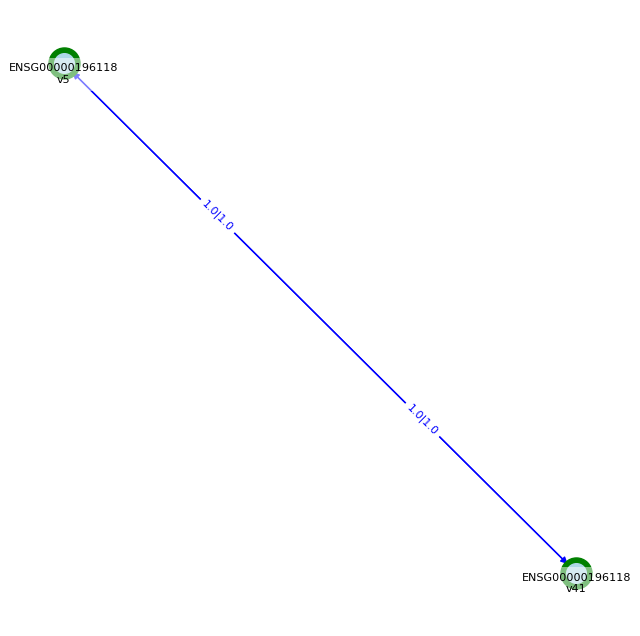

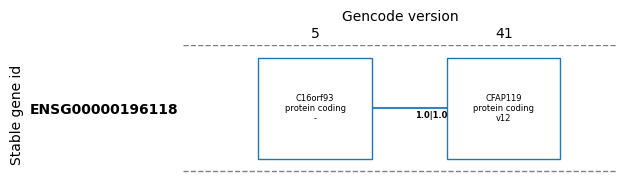

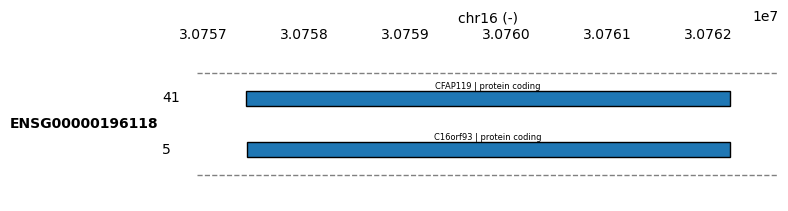

In [120]:
overlap_thr = 0.1
#gene_id = 'ENSG00000268388'
#gene_id = 'ENSG00000259974'
#gene_id = 'ENSG00000280916'
#gene_id = 'ENSG00000253827'
#gene_id = 'ENSG00000254100'
#gene_id = 'ENSG00000251562'
#gene_id = 'ENSG00000224397'
#gene_id = 'ENSG00000245532'
#gene_id = 'ENSG00000245750'
gene_id = 'ENSG00000196118'
plot_history_network(gene_id,DFG,G,overlap_thr=overlap_thr)
plot_history_diagram(gene_id,DFG,G,overlap_thr=overlap_thr)
plot_tracks(gene_id,DFG,G,DFC,overlap_thr=overlap_thr)
